# RAISE.OSIA.IMAGE: ADVANCED PROCESSING

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

### Instructions

This assignment is to be completed individually or in pairs. A report is expected and must be submitted to the designated repository in MLS by the end of the second slot on October 14 at 5 p.m.</br>
The expected document is a Notebook or code+pdf report, the evaluation will take into account:
- use the image processing tools covered in class,
- illustration of results with visualization tools,
- take a step back and analyze the results.

### Objectives

The objectives of this practical assignment are multiple:
- to develop a lossy image compression algorithm that offers the best compromise between compression ratio and distortion
- to use basic ML methods to classify images based on well chosen features

1. Starting from a series of images in PPM format, propose a unique algorithm that allows all these images to be compressed with loss
while controlling distortion.
    1. Helps:
        1. Color spaces don't have same dynamics, use `np.clip()`, `.astype(np.uint8)` $\dots$
        1. You can use the dct: `from scipy.fftpack import dct` the direct DCT is `type=2`, the inverse DCT is `type=3`, to be fully reversible use `norm="ortho"`. Don't forget DCT is separable!
        1. You must save your compressed image in binary file not using image file format (JPEG, PNG, otherwise you will recompress it), use pickle!
        1. Don't try to save floating point numbers, to have better coding (without using Huffman code for instance) use `np.int16` for 16 bit unsigned integer for instance
    1. Illustrates your parameters tuning with plots and compare it with JPEG compression,  compression rate (original image size/ compressed image size in bits) vs. distortion PSNR, $\dots$
        1. The byte size of a file can be computed using `os.path.getsize("/path/to/myfile")`

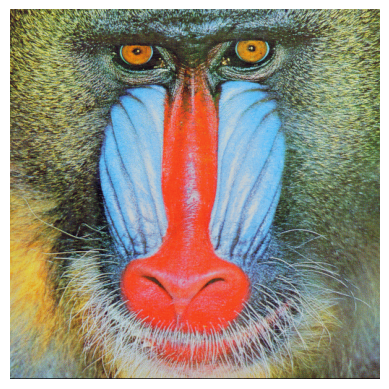

In [ ]:
import imageio.v3 as iio
from scipy.fftpack import dct, idct


# Read image in PPM format
image = io.imread("/content/Baboon.512.ppm")
img = np.array(image)
# Show it
plt.imshow(img)
plt.axis("off")
plt.show()

Conversion to YCbCr format

In [263]:
from scipy.fftpack import dct, idct

def dct2(block): # function to extract the dct from a given block
    return dct(dct(block.T, norm='ortho', type=2).T,norm='ortho', type=2)

def idct2(block): # function to invert the dct from a given block
    return dct(dct(block.T, norm='ortho', type=3).T,norm='ortho', type=3)

'''
Function responsible for encoding each of the 8x8 blocks of an image using DCT.
Before encoding, 128 is subtracted from each pixel in order to center the values
before applying the DCT, thus obtaining smaller values. DCT is then applied to each 8x8 block
and the result is divided by the quantization matrix q and rounded to retain only
the integer part of it.
Finally, the encode_matrix function is used to obtain the encoded vector of the matrix and
it is stored in the encoded_blocks matrix to be returned.
'''
def encoded_matrix_dct(img, q, block_size=8):
  h, w = img.shape
  dct_blocks = np.zeros_like(img, dtype=np.float32)
  encoded_blocks= np.empty((h//block_size, w//block_size), dtype=object)
  for i in range(0, h, block_size):
    for j in range(0, w, block_size):
        block = img[i:i+block_size, j:j+block_size]
        block = block - 128
        dct_block = dct2(block)
        quantized_block = np.round(dct_block / q)
        dct_blocks[i:i+block_size, j:j+block_size] = quantized_block
        encoded_blocks[i//block_size, j//block_size] = encode_matrix(quantized_block)

  return encoded_blocks


'''
This function performs the opposite process to encoding. It receives the complete encoded matrix,
decodes each of the elements, applies IDCT, adds 128, and reconstructs the image.
'''
def encoded_matrix_idct(img, e_matrix, q, block_size=8):
  image = np.zeros_like(img)
  for i in range(e_matrix.shape[0]):
    for j in range(e_matrix.shape[1]):
      encoded_block = e_matrix[i:i+block_size, j:j+block_size]
      matriz_decoded = decode_matrix(e_matrix[i,j])
      dequantized_block = matriz_decoded * q
      image_block = idct2(dequantized_block)
      image_block = image_block + 128
      image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = image_block # Fixed indexing for image reconstruction
  return np.clip(image, 0, 255).astype(np.uint8)

# Fonctions pour encoder et décoder une matrice 8x8

The following functions are necessary to traverse the resulting DCT coefficient matrix after dividing it by Q, in order to subsequently perform compression:

* zigzag(matrix):
This function traverses the matrix in a zigzag pattern, starting with the upper left element, as this is the largest. Upon completing the traversal, it returns the resulting vector.
*   inv_zigzag(vec,n=8):
Taking a vector that would have been constructed with zigzag, this function allows you to obtain the matrix by reversing the process.

* rle_encode(vec):
This function takes a vector with the values obtained by the DCT/q matrix, which may be a vector obtained from the zigzag function, and encodes it in the form of tuples that describe (number of zeros before a number, the number itself). If it reaches the end with a string of several zeros in a row (something that often happens in a DCT/q vector), the tuple (‘EOB’,) is attached, indicating that what remains are zeros.
* rle_decode_ac(rle):
Following the logic of the encoder, in this case this function reads an array of tuples and decodes it to put it in the form of a vector with all the elements, ready for the inverse of the zigzag to be applied to obtain the 8x8 matrix.

* encode_matrix(matrix) and decode_matrix(encode) simply pair the previous zigzag+ rle_encode and dle_decode + inv_zigzag processes.

In [183]:
def zigzag(matrix):

    a = np.asarray(matrix)
    if a.ndim != 2 or a.shape[0] != a.shape[1]:
        raise ValueError("La matriz debe ser cuadrada (n x n).")
    n = a.shape[0]
    out = []
    for s in range(2 * n - 1):
        if s % 2 == 0:
            i = min(s, n - 1)
            i_end = max(0, s - (n - 1))
            while i >= i_end:
                j = s - i
                out.append(a[i, j])
                i -= 1
        else:
            i = max(0, s - (n - 1))
            i_end = min(s, n - 1)
            while i <= i_end:
                j = s - i
                out.append(a[i, j])
                i += 1
    return np.array(out)
def inv_zigzag(vec, n=8):
    v = np.asarray(vec).ravel()
    if v.size != n*n:
        raise ValueError(f"El vector debe tener longitud {n*n}, tiene {v.size}.")
    out = np.empty((n, n), dtype=v.dtype)
    k = 0
    for s in range(2 * n - 1):
        if s % 2 == 0:
            i = min(s, n - 1)
            i_end = max(0, s - (n - 1))
            while i >= i_end:
                j = s - i
                out[i, j] = v[k]; k += 1
                i -= 1
        else:
            i = max(0, s - (n - 1))
            i_end = min(s, n - 1)
            while i <= i_end:
                j = s - i
                out[i, j] = v[k]; k += 1
                i += 1
    return out


def rle_encode(vec):
  out = []
  run = 0
  for i in range(len(vec)):
      if vec[i] == 0:
          run += 1
      else:
          # output (run, value)
          out.append((run, int(vec[i])))
          run = 0
  if run>0:
      out.append(('EOB',))   # end-of-block marker
  return out

def rle_decode_ac(rle):
    ac = []
    for token in rle:
        if token[0]=='EOB':
            # fill remaining with zeros to reach 63
            while len(ac)<64:
                ac.append(0)
            break
        run, val = token
        ac += [0]*run
        ac.append(val)
    # if still short, pad with zeros
    ac += [0]* (64 - len(ac))
    return np.array(ac)

def encode_matrix(matrix):
  vec = zigzag(matrix)
  encode = rle_encode(vec)
  return encode
def decode_matrix(encode):
  vec = rle_decode_ac(encode)
  decode = inv_zigzag(vec)
  return decode

In [296]:
import numpy as np
import gzip, pickle, os

# --- helpers de conversión a tipos "puros" de Python ---
def _to_python(obj):
    """Convierte recursivamente numpy scalars/arrays/tuplas a tipos nativos de Python."""
    if obj is None:
        return None
    if isinstance(obj, (np.integer, np.floating, np.bool_)):
        return obj.item()
    if isinstance(obj, (list, tuple, np.ndarray)):
        return [_to_python(x) for x in obj]
    return obj

def to_serializable(encoded_blocks):
    """
    Convierte np.array(dtype=object) de shape (bh,bw) a lista de listas de objetos nativos.
    """
    bh, bw = encoded_blocks.shape
    out = []
    for i in range(bh):
        row = []
        for j in range(bw):
            blk = encoded_blocks[i, j]
            row.append(_to_python(blk))
        out.append(row)
    return out

def from_serializable(list_of_lists):
    """
    Reconstruye np.array(dtype=object) desde la estructura lista-de-listas.
    """
    arr = np.empty((len(list_of_lists), len(list_of_lists[0])), dtype=object)
    for i, row in enumerate(list_of_lists):
        for j, blk in enumerate(row):
            # convertir listas internas a tuplas si originalmente tus tokens eran tuplas
            # (opcional). Aquí dejamos los elementos tal cual (listas de listas).
            arr[i, j] = blk
    return arr

# --- guardar / cargar ---
def save_encoded_color(encoded_y, encoded_cb, encoded_cr, img_shape, q, block_size, path):

    payload = {
        "meta": {"img_shape": img_shape, "block_size": block_size, "q": q},
        "Y": to_serializable(encoded_y),
        "Cb": to_serializable(encoded_cb),
        "Cr": to_serializable(encoded_cr)
    }
    with gzip.open(path, "wb") as f:
        pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_encoded_color(path):
    with gzip.open(path, "rb") as f:
        payload = pickle.load(f)
    # Reconstruir en np.array(dtype=object) si lo prefieres:
    payload["Y"]  = from_serializable(payload["Y"])
    payload["Cb"] = from_serializable(payload["Cb"])
    payload["Cr"] = from_serializable(payload["Cr"])
    return payload


In [312]:
from skimage.color import rgb2ycbcr, ycbcr2rgb

def dtc_completo(img, q, nom, block_size=8):
  img_ycbcr = rgb2ycbcr(img)
  img_y = img_ycbcr[:,:,0]
  img_cb = img_ycbcr[:,:,1]
  img_cr = img_ycbcr[:,:,2]

  y_dct_coeficients = encoded_matrix_dct(img_y, q, block_size=8)
  cb_dct_coeficients = encoded_matrix_dct(img_cb, q, block_size=8)
  cr_dct_coeficients = encoded_matrix_dct(img_cr, q, block_size=8)

  save_encoded_color(y_dct_coeficients, cb_dct_coeficients, cr_dct_coeficients, img.shape, q, block_size, nom)

  data = load_encoded_color(nom)

  y_decompressed = encoded_matrix_idct(img_y,data["Y"], q, block_size=8)
  cb_decompressed = encoded_matrix_idct(img_cb, data["Cb"], q, block_size=8)
  cr_decompressed = encoded_matrix_idct(img_cb, data["Cr"], q, block_size=8)


  new_ycbcr = np.zeros_like(img_ycbcr)
  new_ycbcr[:,:,0] = y_decompressed
  new_ycbcr[:,:,1] = cb_decompressed
  new_ycbcr[:,:,2] = cr_decompressed
  new_rgb = ycbcr2rgb(new_ycbcr)
  new_rgb = np.clip(new_rgb, 0, 1)
  new_rgb = (new_rgb * 255).astype(np.uint8)
  return new_rgb

In [311]:
def dtc_completo_descompress(img, q, nom, block_size=8):
  data = load_encoded_color(nom)
  new_ycbcr = np.zeros_like(img)
  new_ycbcr[:,:,0] = data["Y"]
  new_ycbcr[:,:,1] = data["Cb"]
  new_ycbcr[:,:,2] = data["Cr"]
  new_rgb = ycbcr2rgb(new_ycbcr)
  new_rgb = np.clip(new_rgb, 0, 1)
  new_rgb = (new_rgb * 255).astype(np.uint8)

In [204]:
q_1 = np.zeros((8, 8), dtype=int)
for i in range(8):
  for j in range(8):
    q_1[i,j] = 100

new_1 = dtc_completo(img, q_1,"q1", block_size=8)

In [222]:

q_2 = np.zeros((8, 8), dtype=int)
for i in range(8):
  for j in range(8):
    q_2[i,j] = 10+5*i+5*j
print(q_2)
new_2 = dtc_completo(img, q_2, "q2", block_size=8)


[[10 15 20 25 30 35 40 45]
 [15 20 25 30 35 40 45 50]
 [20 25 30 35 40 45 50 55]
 [25 30 35 40 45 50 55 60]
 [30 35 40 45 50 55 60 65]
 [35 40 45 50 55 60 65 70]
 [40 45 50 55 60 65 70 75]
 [45 50 55 60 65 70 75 80]]


In [229]:
q_3 = np.zeros((8, 8), dtype=int)
for i in range(8):
  for j in range(8):
    q_3[i,j] = 10+7*i+7*j
print(q_3)
new_3 = dtc_completo(img, q_3, "q3", block_size=8)


[[ 10  17  24  31  38  45  52  59]
 [ 17  24  31  38  45  52  59  66]
 [ 24  31  38  45  52  59  66  73]
 [ 31  38  45  52  59  66  73  80]
 [ 38  45  52  59  66  73  80  87]
 [ 45  52  59  66  73  80  87  94]
 [ 52  59  66  73  80  87  94 101]
 [ 59  66  73  80  87  94 101 108]]


In [206]:
q_jpeg =  np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=np.int16)

new_jpeg = dtc_completo(img, q_jpeg, "jpeg", block_size=8)

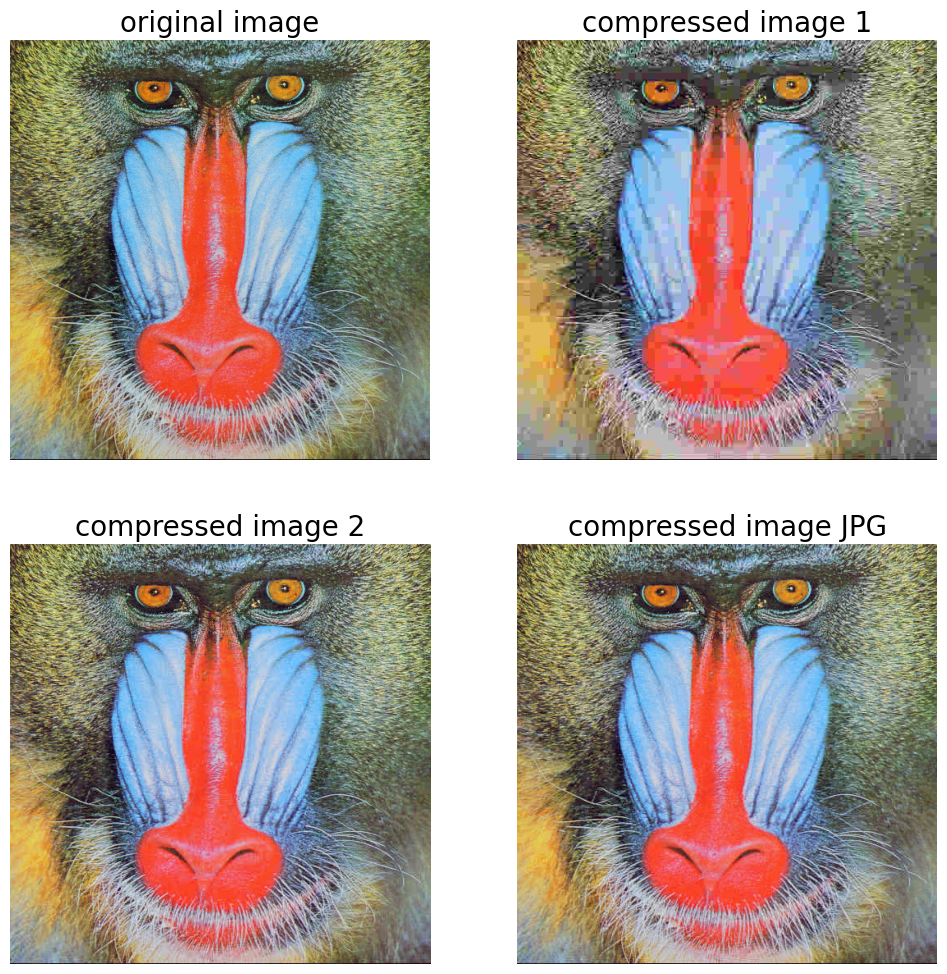

In [207]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img)
plt.axis('off')
plt.title('original image', size=20)

plt.subplot(222)
plt.imshow(new_1)
plt.axis('off')
plt.title('compressed image 1', size=20)

plt.subplot(223)
plt.imshow(new_2)
plt.axis('off')
plt.title('compressed image 2', size=20)

plt.subplot(224)
plt.imshow(new_jpeg)
plt.axis('off')
plt.title('compressed image JPG', size=20)
plt.show()



Guardar la imagen como binario con pickle

Ahora se busca comparar los resultados obtenidos con respecto a los que se optendrían con un Q de jpeg


In [297]:
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [298]:
import os

original_size = os.path.getsize("Baboon.512.ppm")
jpg_size = os.path.getsize("jpeg")
jpg_ratio = original_size/jpg_size
jpg_psnr = calculate_psnr(img, new_jpeg)

In [310]:
a_bs = []
qs = []
new_img =[]
for i in range(200):
  a = np.random.randint(3, 100)
  b = np.random.randint(1, 40)
  q_n = np.zeros((8, 8), dtype=int)
  for i in range(8):
    for j in range(8):
      q_n[i,j] = a+b*i+b*j
  a_bs.append([a,b])
  qs.append(q_n)
  new_img.append(dtc_completo(img, q_n, f"q_a{a}_b{b}", block_size=8))


Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega
Aqui llega

In [313]:
ratios = []
psnrs = []
i =0
for a,b in a_bs:
  img_size = os.path.getsize(f"q_a{a}_b{b}")
  ratio = original_size/img_size
  ratios.append(ratio)
  new_psnr = calculate_psnr(img, new_img[i])
  psnrs.append(new_psnr)
  i+=1

In [314]:
# Calcular el tamaño real a partir del ratio
sizes = original_size / np.array(ratios)

# Filtrar las opciones eficientes según el nuevo criterio
efficient_idx = []
for i in range(len(ratios)):
    if (psnrs[i] > jpg_psnr and sizes[i] <= jpg_size) or \
       (abs(psnrs[i] - jpg_psnr) < 1e-3 and sizes[i] < jpg_size):
        efficient_idx.append(i)

# Mostrar resultados
if efficient_idx:
    print(f"✅ {len(efficient_idx)} options more efficient than JPEG were found\n")
    for i in efficient_idx:
        a, b = a_bs[i]
        print(f" - a={a}, b={b} | Ratio={ratios[i]:.2f}, PSNR={psnrs[i]:.2f} dB | Size={sizes[i]:.0f} bytes")
else:
    print("❌ No option more efficient than JPEG was found according to the new criteria.")

✅ 5 options more efficient than JPEG were found

 - a=4, b=6 | Ratio=6.24, PSNR=24.44 dB | Size=126040 bytes
 - a=32, b=1 | Ratio=8.24, PSNR=24.12 dB | Size=95485 bytes
 - a=19, b=2 | Ratio=6.06, PSNR=25.06 dB | Size=129823 bytes
 - a=12, b=4 | Ratio=6.60, PSNR=24.64 dB | Size=119099 bytes
 - a=20, b=3 | Ratio=7.65, PSNR=24.33 dB | Size=102815 bytes


6.032700745604615 23.89226


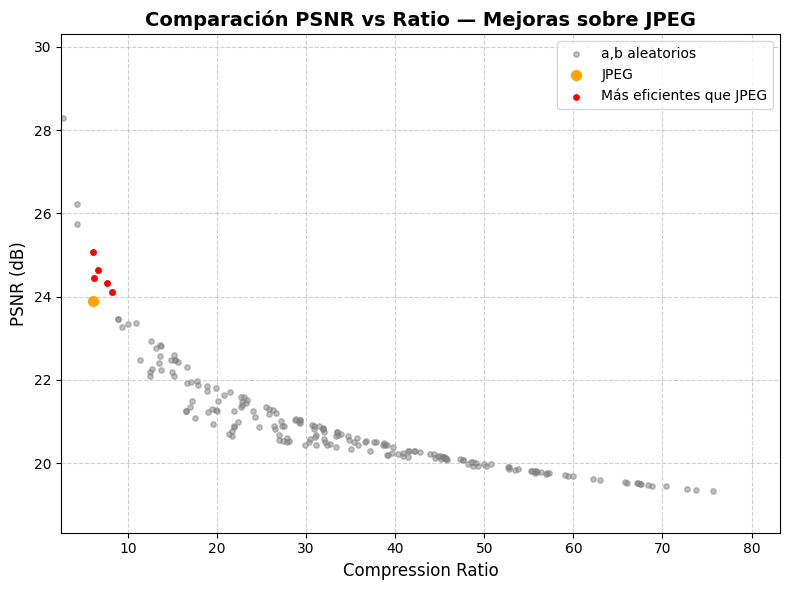

In [315]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Puntos generales (todos)
plt.scatter(ratios, psnrs, color='gray', s=15, alpha=0.5, label='a,b aleatorios')

# JPEG como referencia
plt.scatter(jpg_ratio, jpg_psnr, color='orange', s=50, marker='o', label='JPEG')
print(jpg_ratio, jpg_psnr)
# Marcar las opciones eficientes (si existen)
if efficient_idx:
    plt.scatter(np.array(ratios)[efficient_idx], np.array(psnrs)[efficient_idx],
                color='red', s=15, marker='o', label='Más eficientes que JPEG')


plt.title("Comparación PSNR vs Ratio — Mejoras sobre JPEG", fontsize=14, fontweight='bold')
plt.xlabel("Compression Ratio", fontsize=12)
plt.ylabel("PSNR (dB)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Límites automáticos
plt.xlim(min(ratios)*0.9, max(ratios)*1.1)
plt.ylim(min(psnrs)-1, max(psnrs)+2)

plt.tight_layout()
plt.show()

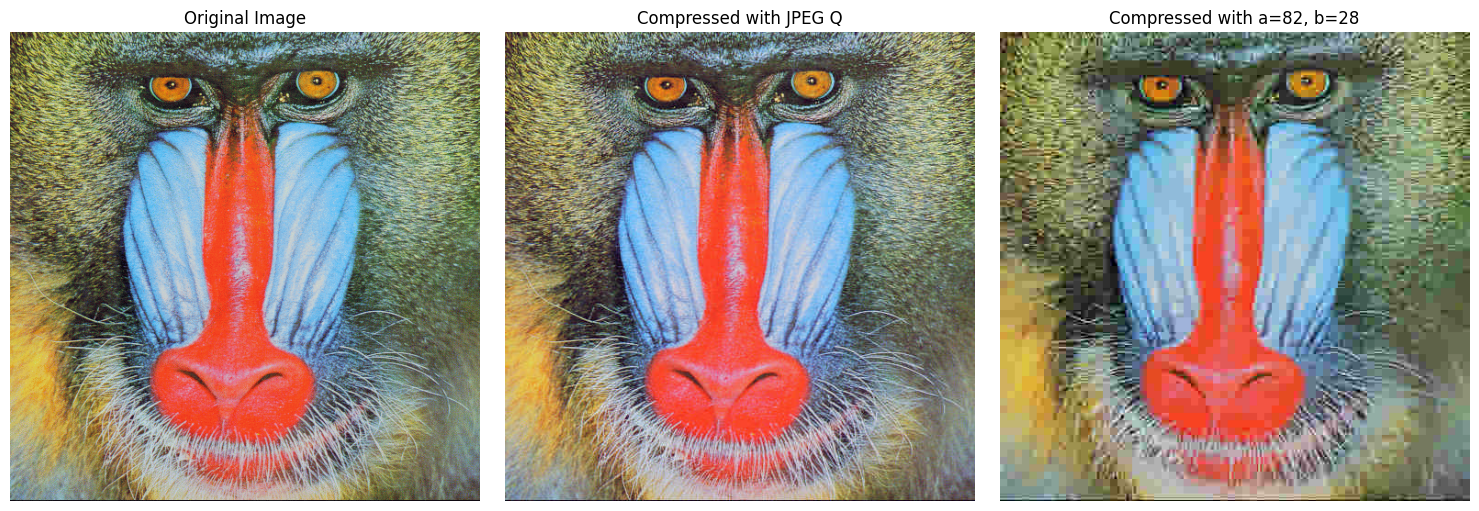

In [276]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(new_jpeg)
plt.title('Compressed with JPEG Q')
plt.axis('off')

# Assuming that the image compressed with a=82 and b=28 is available.
# Based on previous code, this image was generated and saved to 'q_a82_b28'.
# I will load this image to display it.
# However, the function 'dtc_completo' returns the decompressed image directly,
# so I'll use the 'new_img' list from cell 'lAYNyjOI0dM6' or regenerate it.
# Given the uncertainty of which index in new_img corresponds to a=82 and b=28,
# and to ensure the correct image is displayed, I will regenerate the image with these parameters.
# This requires the definition of dtc_completo and the original image 'img' to be available.

# Regenerate the compressed image with a=82 and b=28 for display
q_82_28 = np.zeros((8, 8), dtype=int)
for i in range(8):
  for j in range(8):
    q_82_28[i,j] = 82 + 28*i + 28*j # Using a=82 and b=28

# Assuming dtc_completo is defined and 'img' is loaded
try:
    img_82_28_compressed = dtc_completo(img, q_82_28, "q_a82_b28_display", block_size=8)

    plt.subplot(1, 3, 3)
    plt.imshow(img_82_28_compressed)
    plt.title('Compressed with a=82, b=28')
    plt.axis('off')

except NameError:
    print("Error: 'dtc_completo' or 'img' not defined. Please ensure necessary cells are run.")


plt.tight_layout()
plt.show()

PSNR is a mathematical metric based on the mean squared error (MSE) between the original and compressed images. It's easy to calculate and widely used, but it doesn't always correlate well with human visual perception.

Our visual system is complex and is more sensitive to certain types of errors than others. For example, we are generally more sensitive to errors in smooth areas than in textured areas. Also, our perception of quality can be influenced by factors like the type of distortion (e.g., blocking artifacts vs. blurring) and the specific content of the image.

In this case, even though the image compressed with a=82 and b=28 has a higher PSNR, it might introduce distortions that are more visually noticeable or unpleasant to the human eye compared to the distortions introduced by the JPEG quantization matrix, which was designed based on psycho-visual studies to minimize perceived distortion.

So, while PSNR can be a useful objective metric, it's important to also consider subjective visual assessment and other perceptual quality metrics when evaluating image compression algorithms.

PSNR is a mathematical metric based on the mean squared error (MSE) between the original and compressed images. It's easy to calculate and widely used, but it doesn't always correlate well with human visual perception.

Our visual system is complex and is more sensitive to certain types of errors than others. For example, we are generally more sensitive to errors in smooth areas than in textured areas. Also, our perception of quality can be influenced by factors like the type of distortion (e.g., blocking artifacts vs. blurring) and the specific content of the image.

In this case, even though the image compressed with a=82 and b=28 has a higher PSNR, it might introduce distortions that are more visually noticeable or unpleasant to the human eye compared to the distortions introduced by the JPEG quantization matrix, which was designed based on psycho-visual studies to minimize perceived distortion.

So, while PSNR can be a useful objective metric, it's important to also consider subjective visual assessment and other perceptual quality metrics when evaluating image compression algorithms.

Thanks to this random method a and b, several values a and b were obtained, which allow for greater compression than the JPEG format while weighing the same or less.

2. Image recognition: Digit recognition
    1. Direct Image classification
        1. Load the dataset and display some images
        1. Use the whole image as features to train and test some basics ML methods (from scikit-learn). Display results and comment.

    1. Image features
        1. Choose one PPM image and compute the HOG (Histogram of Gradient Feature, first introduced by Dalal and Triggs in 2005 as a robust feature extraction method), `hog_feature, hog_image = feature.hog(img, visualize=True)`, display the `hog_feature` as histogram and `hog_image` as image. Your image is in color so you should use `channel_axis=2`. As default parameters you can use: `pixels_per_cell=(16, 16), cells_per_block=(1, 1)`.
        HOG features can be seen as edge descriptors computed by bloc and then aggregated into an histogram.
        1. Use HOG features for the images and classify using the same set up.
        1. Suppose we compress the test dataset (with JPEG QF=75), and classify using the same set up, what can we expect?  

In [274]:
from sklearn.datasets import fetch_openml
import pandas as pd

In [275]:
mnist = fetch_openml('mnist_784')

In [ ]:
X, y = mnist["data"], mnist["target"]

# Split into train and test sets
X_train, X_test = np.array(X[:60000],dtype=np.uint8), np.array(X[60000:],dtype=np.uint8)
y_train, y_test = np.array(y[:60000],dtype=np.uint8), np.array(y[60000:],dtype=np.uint8)

In [ ]:
def display_image(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

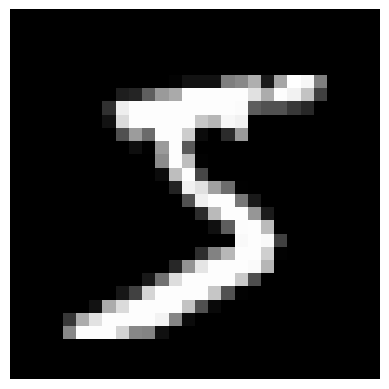

np.uint8(5)

In [ ]:
display_image(X_train[0])
y_train[0]

3. Photographic mosaic. The idea is to generate a large mosaic image from a large database of small images called thumbnails. The principle of the method consists of taking a large image, cutting it into small blocks, and replacing each block of the large image with the most similar thumbnail from the large thumbnail database. https://en.wikipedia.org/wiki/Photographic_mosaic
    1. Chose a large image
    1. Get a large image dataset from internet
    1. Split your image into blocs. What is a good bloc size?
    1. Compute a criteria for each bloc (first try the mean value), it will be used to match with thumbnails
    1. Display the bloc image, where each bloc of the image is replaced by the criteria
    1. Generate the mosaic by replacing each bloc of the image by the resized image that minimize the distance between their critaria values
    1. What criteria could be used instead? With witch distance? Try it!